In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def json_dump(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f)
        
def q_error(actual, pred):
    epsilon = 1e-4
    q_e = 0
    for i in range(len(pred)):
        q_e += max((actual[i]+epsilon)/(pred[i]+epsilon),(pred[i]+epsilon)/(actual[i]+epsilon))
    return q_e/len(pred)

In [2]:
import ast
import re
from collections import OrderedDict
from selection.data_preparation import read_csv, index_conversion
from selection.workload import Query, Index, Column, Table
from constant import TPC_DS_TABLE_PREFIX, TPC_H_TABLE_PREFIX, LOGICAL_OPERATORS, PHYSICAL_OPERATORS, PHYISCAL_TO_LOGICAL_OPERATOR_MAP

In [3]:
def read_table_info(row_info_filepath, column_info_filepath):
    data_table_info = read_csv(row_info_filepath)[2:-2]
    table_dict = OrderedDict()
    for table_info in data_table_info:
        table_info_tuple = table_info[0].split('|')
        if len(table_info_tuple) < 2: continue
        table_name = table_info_tuple[0].strip()
        row_count = float(table_info_tuple[1].strip())
        table = Table(table_name)
        table.set_row_count(row_count)
        table_dict[table_name] = table
        
    TABLE_PREFIX_MAP = None
    if re.search("TPC_DS", column_info_filepath) or re.search("dsb", column_info_filepath):
        TABLE_PREFIX_MAP = TPC_DS_TABLE_PREFIX
    elif re.search("TPCH", column_info_filepath):
        TABLE_PREFIX_MAP = TPC_H_TABLE_PREFIX
    elif re.search("IMDB", column_info_filepath): 
        TABLE_PREFIX_MAP = None
    else: 
        raise ValueError("Specified dataset not supported")
    
    data_column_info = read_csv(column_info_filepath)[2:-2]
    column_dict = OrderedDict()
    for column_info in data_column_info:
        column_info_tuple = column_info[0].split('|')
        if len(column_info_tuple) < 3: continue
        
        if TABLE_PREFIX_MAP == None:
            ## IMDB
            table_name = column_info_tuple[0].strip()
            column_name = column_info_tuple[1].strip()
            null_frac = float(column_info_tuple[2].strip())
            n_distinct = float(column_info_tuple[3].strip())
            column = Column(column_name)
            column.set_cardinality(-n_distinct * row_count if n_distinct < 0 else n_distinct)
            column.set_null_fraction(null_frac)
            if table_name in table_dict.keys():
                column.table = table_dict[table_name]
                column.table.add_column(column)
        else:
            column_name = column_info_tuple[0].strip()
            null_frac = float(column_info_tuple[1].strip())
            n_distinct = float(column_info_tuple[2].strip())
            column = Column(column_name)
            column.set_cardinality(-n_distinct * row_count if n_distinct < 0 else n_distinct)
            column.set_null_fraction(null_frac)
            if (prefix := column_name.split('_')[0]) in TABLE_PREFIX_MAP.keys():
                table_name = TABLE_PREFIX_MAP[prefix]
                if table_name in table_dict.keys():
                    column.table = table_dict[table_name]
                    column.table.add_column(column)      
        column_dict[column_name] = column
    return table_dict, column_dict

In [4]:
table_dict_DS_50G, column_dict_DS_50G = read_table_info("../data/TPC_DS_50G/tpcds50trow.csv", "../data/TPC_DS_50G/tpcds50stats.csv")
table_dict_DS_10G, column_dict_DS_10G = read_table_info("../data/TPC_DS_10G/tpcds10trow.csv", "../data/TPC_DS_10G/tpcds10stats.csv")
table_dict_H, column_dict_H = read_table_info("../data/TPCH/tpchtrow.csv", "../data/TPCH/tpchstats.csv")
# table_dict_DSB, column_dict_DSB = read_table_info("../data/DSB/dsbrow.csv", "../data/DSB/dsbstats.csv")

In [5]:
table_dict_IMDB, column_dict_IMDB = read_table_info("../data/IMDB/imdb_trows.csv", "../data/IMDB/imdb_stats.csv")

In [6]:
len(table_dict_DS_50G), len(table_dict_DS_10G), len(table_dict_H), len(table_dict_IMDB)

(25, 25, 8, 20)

In [7]:
len(column_dict_DS_50G), len(column_dict_DS_10G), len(column_dict_H), len(column_dict_IMDB)

(425, 425, 61, 38)

In [8]:
def convert_configuration_to_obj(columns_dict, config_string):
    configs = []
    for config_s in config_string:
        if config_s == "[]": 
            configs.append([])
            continue
        config = []
        indexes_s = config_s.split('I')
        for index_s in indexes_s:
            if index_s == '': continue
            table_columns = index_s.split('C')
            indexed_columns = []
            for table_column in table_columns:
                table_column = table_column.strip('(), ')
                if table_column == '': continue
                column_name = table_column.split('.')[-1]
                if column_name in columns_dict:
                    indexed_columns.append(columns_dict[column_name])
            config.append(Index(indexed_columns))
        configs.append(config)
    return configs

In [9]:
def read_query_and_index_data(filepath, column_dict):
    # data_list[i][0]: Query ID and Query text for the i-th query
    # data_list[i][1]: Index configurations for the i-th query
    # data_list[i][2]: Average cost of each configuration for the i-th query
    # data_list[i][3]: Query execution plan of each configuration for the i-th query
    # data_list[i][4]: Details execution costs (each query is executed 4 times and the last 3 times are recorded) of each configuration for the i-th query

    data_list_string = read_csv(filepath)
    data, queries = [], []
    for i in range(len(data_list_string)):
        data_list_string[i][0] = ast.literal_eval(data_list_string[i][0])
        query = Query(data_list_string[i][0][0], data_list_string[i][0][1])
        query.columns = [column for column_name, column in column_dict.items() if column_name in query.text]
        queries.append(query)
        indexes_string = index_conversion(data_list_string[i][1])
        index_configurations = convert_configuration_to_obj(column_dict, indexes_string)
        average_costs = ast.literal_eval(data_list_string[i][2])
        plans = ast.literal_eval(data_list_string[i][3])
        data.append([query, index_configurations, average_costs, plans])
    return data, queries

In [10]:
IMDB_data, _ = read_query_and_index_data("../data/IMDB/imdb_job.csv",column_dict_IMDB)

In [11]:
DS_50G_data, _ = read_query_and_index_data("../data/TPC_DS_50G/TPC_DS_50GB.csv", column_dict_DS_50G)

In [12]:
DS_10G_data, _ = read_query_and_index_data("../data/TPC_DS_10G/TPC_DS_10GB.csv", column_dict_DS_10G)
H_data, _ = read_query_and_index_data("../data/TPCH/TPC_H_10.csv", column_dict_H)

In [13]:
# DSB_data, _ = read_query_and_index_data("../data/DSB/dsb.csv", column_dict_DSB)

### Index Filter

#### Labels

In [14]:
def has_child_node(query_plan):
    return "Plans" in query_plan.keys()

def has_filtering_property(query_plan):
    if "Filter" in query_plan.keys():
        return query_plan["Filter"]
    if "Hash Cond" in query_plan.keys():
        return query_plan["Hash Cond"]
    if "Join Filter" in query_plan.keys():
        return query_plan["Join Filter"]
    return ""

def is_join_operator(operator):
    return PHYISCAL_TO_LOGICAL_OPERATOR_MAP[operator] == "Join"

def is_sort_operator(operator):
    return PHYISCAL_TO_LOGICAL_OPERATOR_MAP[operator] == "Sort"

def is_aggregate_operator(operator):
    return PHYISCAL_TO_LOGICAL_OPERATOR_MAP[operator] == "Aggregate"

def is_scan_operator(operator):
    return PHYISCAL_TO_LOGICAL_OPERATOR_MAP[operator] == "Scan"

def check_indexed_column_in_condition(index, condition):
    for column in index.columns:
        if column.name in condition:
            return True

def get_table_from_plan_node(query_plan):
    table = ""
    if "Relation Name" in query_plan.keys():
        table = query_plan["Relation Name"]
    return table

In [15]:
def _collect_physical_operators(physical_operators, query_plan): 
    physical_operators.add(query_plan["Node Type"])
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _collect_physical_operators(physical_operators, child_node)
            
def collect_physical_operators(data):
    physical_operators = set()
    for sample in data:
        query_plans = sample[3]
        for query_plan in query_plans:
            _collect_physical_operators(physical_operators, query_plan)
    return physical_operators


physical_operators = collect_physical_operators(DS_10G_data)
physical_operators.union(collect_physical_operators(DS_50G_data))
physical_operators.union(collect_physical_operators(H_data))
physical_operators.union(collect_physical_operators(IMDB_data))
physical_operators = list(physical_operators)  

#### Feautures

In [16]:
# signal 1
def estimate_index_utility(index, original_query_plan, indexed_query_plan):
    total_cost = 0
    if has_child_node(original_query_plan):
        for original_child_node, indexed_child_node in zip(indexed_query_plan["Plans"], indexed_query_plan["Plans"]):
            total_cost += estimate_index_utility(index, original_child_node, indexed_child_node)
    current_operator = indexed_query_plan["Node Type"]
    current_cost = original_query_plan["Total Cost"]
    if (condition := has_filtering_property(indexed_query_plan)) != "":
        if is_join_operator(current_operator):
            join_output_rows = indexed_query_plan["Plan Rows"]
            left_input_rows = indexed_query_plan["Plans"][0]["Plan Rows"]
            right_input_rows = indexed_query_plan["Plans"][1]["Plan Rows"]
            if check_indexed_column_in_condition(index, condition):    
                current_cost = (1-np.sqrt(join_output_rows/(left_input_rows*right_input_rows)))*original_query_plan["Total Cost"]
        else:
            selectivities = [indexed_query_plan["Plan Rows"]/column.table.row_count for column in index.columns if column.name in condition]
            average_selectivity = sum(selectivities)/len(selectivities) if len(selectivities) > 0 else 0
            current_cost = (1-average_selectivity)*original_query_plan["Total Cost"]
    elif is_sort_operator(current_operator) and "Sort Key" in indexed_query_plan.keys():
        sort_conditions = indexed_query_plan["Sort Key"]
        for sort_condition in sort_conditions:
            if check_indexed_column_in_condition(index, sort_condition):
                current_cost = indexed_query_plan["Total Cost"]
    elif is_aggregate_operator(current_operator) and "Group Key" in indexed_query_plan.keys():
        group_conditions = indexed_query_plan["Group Key"]
        for group_condition in group_conditions:
            if check_indexed_column_in_condition(index, group_condition):
                current_cost = indexed_query_plan["Total Cost"]
    return total_cost+current_cost

In [17]:
# signal 2
def extract_shape_of_query_and_index(index, original_query_plan, indexed_query_plan):
    query_shape, index_shape = {}, []
    _extract_query_shape(query_shape, original_query_plan)
    visited = set()
    _extract_index_shape(index_shape, index, indexed_query_plan, visited)
    return query_shape, index_shape

def _extract_query_shape(query_shape, query_plan):
    current_operator = query_plan["Node Type"]
    logical_operator = PHYISCAL_TO_LOGICAL_OPERATOR_MAP[current_operator]
    if is_scan_operator(current_operator):
        table = get_table_from_plan_node(query_plan)
        if table in query_shape.keys():
            query_shape[table].append(logical_operator)
        else:
            query_shape[table] = [logical_operator]
        return table
    
    tables = []    
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            table = _extract_query_shape(query_shape, child_node)
            if table and logical_operator:
                tables.append(table)
                query_shape[table].append(logical_operator)
    return tables[0] if 0<len(tables)<2 else ""

def _extract_index_shape(index_shape, index, query_plan, visited):
    current_operator = query_plan["Node Type"]
    logical_operator = PHYISCAL_TO_LOGICAL_OPERATOR_MAP[current_operator]
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _extract_index_shape(index_shape, index, child_node, visited)
            
    if (condition := has_filtering_property(query_plan)) != "":
        for column in index.columns:
            if column in visited: continue
            elif column.name in condition:
                index_shape.append(logical_operator)
                visited.add(column)
    elif is_sort_operator(current_operator) and "Sort Key" in query_plan.keys():
        sort_conditions = query_plan["Sort Key"]
        for sort_condition in sort_conditions:
            for column in index.columns:
                if column in visited: continue
                elif column.name in sort_condition:
                    index_shape.append(logical_operator)
                    visited.add(column)
    elif is_aggregate_operator(current_operator) and "Group Key" in query_plan.keys():
        aggregate_conditions = query_plan["Group Key"]
        for aggregate_condition in aggregate_conditions:
            for column in index.columns:
                if column in visited: continue
                elif column.name in aggregate_condition:
                    index_shape.append(logical_operator)
                    visited.add(column)

In [18]:
# signal 3
def evaluate_operator_relevance(index, query_plan):
    result = {}
    _evaluate_operator_relevance(result, index, query_plan)
    return result

def _evaluate_operator_relevance(operator_relevance, index, query_plan):
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _evaluate_operator_relevance(operator_relevance, index, child_node)
            
    current_operator = query_plan["Node Type"]
    relevance = 0
    if (condition := has_filtering_property(query_plan)) != "":
        selectivities = [query_plan["Plan Rows"]/column.table.row_count for column in index.columns if column.name in condition]
        relevance = sum(selectivities)/len(selectivities) if len(selectivities) > 0 else 0
    elif is_sort_operator(current_operator) and "Sort Key" in query_plan.keys():
        densities = []
        conditions = query_plan["Sort Key"]
        for condition in conditions:
            for column in index.columns:
                if column.name in condition:
                    densities.append(column.cardinality/column.table.row_count)
        relevance = sum(densities)/len(densities) if len(densities) > 0 else 0
    elif is_aggregate_operator(current_operator) and "Group Key" in query_plan.keys():
        densities = []
        conditions = query_plan["Group Key"]
        for condition in conditions:
            for column in index.columns:
                if column.name in condition:
                    densities.append(column.cardinality/column.table.row_count)
        relevance = sum(densities)/len(densities) if len(densities) > 0 else 0
    if current_operator not in operator_relevance: 
        operator_relevance[current_operator] = []
    operator_relevance[current_operator].append(relevance)

In [19]:
# signal 4
def get_number_of_pages(query_plan):
    return query_plan["Shared Hit Blocks"] + query_plan["Shared Read Blocks"] + query_plan["Local Hit Blocks"] + query_plan["Local Read Blocks"]

# check primary key instead
# not used
def count_clustered_index(db_connector, table_name):
    count = db_connector.count_clustered_indexes(table_name)
    return count

def check_bitmap(query_plan):
    current_operator = query_plan["Node Type"]
    use = False
    if is_scan_operator(current_operator):
        use = "Bitmap" in current_operator
    
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            use |= check_bitmap(child_node)
    return use

In [19]:
MAX_TABLE_NUM = 25
def construct_features_and_labels(data, table_dict):
    labels = []
    feature_columns = ["utility", "num_pages", "use_bitmap"]
    operator_relevance_columns = [f"relevance_{operator}" for operator in LOGICAL_OPERATORS]
    feature_columns.extend(operator_relevance_columns)
    query_shape_columns = [f"query_shape_operator{i}_on_table{j}" for j in range(MAX_TABLE_NUM+1) for i in range(5)]
    feature_columns.extend(query_shape_columns)
    index_shape_columns = [f"index_shape_operator{i}" for i in range(5)]
    feature_columns.extend(index_shape_columns)

    single_index_query_ids = [(i,j) for i, entry in enumerate(data) for j, config in enumerate(entry[1]) if len(config) == 1]
    features = pd.DataFrame(columns=feature_columns, index=range(len(single_index_query_ids)))

    for k, (i,j) in enumerate(single_index_query_ids):
        index_configs = data[i][1]
        costs = data[i][2]
        plans = data[i][3]
        
        # only consider single index config
        index = index_configs[j][0]
        labels.append(costs[j])
        original_query_plan = plans[0] # no indexed query plan
        original_query_cost = costs[0] # no index query cost
        indexed_query_plan = plans[j]
        utility = estimate_index_utility(index, original_query_plan, indexed_query_plan)/original_query_cost
        query_shape, index_shape = extract_shape_of_query_and_index(index, original_query_plan, indexed_query_plan)
        table_keys = [table_key for table_key,_ in table_dict.items()]
        for table, operator_seq in query_shape.items():
            for j, operator in enumerate(operator_seq):
                if table in table_keys:
                    table_index = table_keys.index(table)
                    features.iloc[k][f"query_shape_operator{j}_on_{table_index}"] = operator
        for j, operator in enumerate(index_shape):
            features.iloc[k][f"index_shape_operator{j}"] = operator
        relevance = evaluate_operator_relevance(index, original_query_plan)
        for operator in LOGICAL_OPERATORS:
            if operator in relevance: features.iloc[k][f"relevance_{operator}"] = sum(relevance[operator])/len(relevance[operator])
            else: features.iloc[k][f"relevance_{operator}"] = 0
        num_pages = get_number_of_pages(indexed_query_plan)
        use_bitmap = check_bitmap(indexed_query_plan)
        features.iloc[k]["utility"] = utility
        features.iloc[k]["num_pages"] = num_pages
        features.iloc[k]["use_bitmap"] = int(use_bitmap)
        
    features[["utility", "num_pages"]+operator_relevance_columns] = features[["utility", "num_pages"]+operator_relevance_columns].apply(pd.to_numeric)
    features["use_bitmap"] = features["use_bitmap"].astype('int')
    
    return features, labels, single_index_query_ids



features_DS_50G, labels_DS_50G, single_index_query_ids_DS_50G = construct_features_and_labels(DS_50G_data, table_dict_DS_50G)
features_DS_10G, labels_DS_10G, single_index_query_ids_DS_10G = construct_features_and_labels(DS_10G_data, table_dict_DS_10G)
features_H, labels_H, single_index_query_ids_H = construct_features_and_labels(H_data, table_dict_H)
# features_DSB, labels_DSB, single_index_query_ids_DSB = construct_features_and_labels(DSB_data, table_dict_DSB)
print("labels:\n", labels_DS_10G)
features_DS_10G

labels:
 [3821.840666666667, 16285.343666666668, 117.93266666666666, 6416.822666666667, 6354.952333333334, 6355.659666666666, 6457.203666666665, 6407.342666666666, 6349.016333333333, 6415.018666666667, 6649.308666666667, 4284.687999999999, 4400.314333333333, 4409.274666666667, 4306.645, 2499.605666666667, 2430.9223333333334, 1219.0106666666668, 148.68966666666668, 518.3246666666666, 493.834, 2563.286, 2632.2236666666663, 2532.9833333333336, 2638.4143333333336, 2631.3766666666666, 1159.6956666666667, 387.03099999999995, 1093.7616666666665, 2532.7793333333334, 1421.9309999999998, 2114.7153333333335, 2479.487333333333, 2542.610666666667, 2549.241, 2155.045, 1119.1516666666666, 2138.8213333333333, 2019.4913333333334, 2041.689333333333, 2149.953666666667, 927.7326666666668, 180.31333333333336, 844.1093333333333, 5028.141333333333, 4871.205666666666, 1515.2766666666666, 5094.430333333333, 70961.72466666666, 54874.82233333334, 51074.741, 52452.49966666667, 52518.73233333334, 51555.38433333333

,utility,num_pages,use_bitmap,relevance_Scan,relevance_Join,relevance_Aggregate,relevance_Sort,query_shape_operator0_on_table0,query_shape_operator1_on_table0,query_shape_operator2_on_table0,...,query_shape_operator0_on_table25,query_shape_operator1_on_table25,query_shape_operator2_on_table25,query_shape_operator3_on_table25,query_shape_operator4_on_table25,index_shape_operator0,index_shape_operator1,index_shape_operator2,index_shape_operator3,index_shape_operator4
0,2901.467276,562857,0,0,0,56.402088,56.402088,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Aggregate,NaN,NaN,NaN,NaN
1,901.182714,525494,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
2,37.172649,60772,1,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3911.049982,1361424,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
4,3709.016622,1393972,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706,4334.308592,525443,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
1707,3914.950787,1324316,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1708,4330.627794,524140,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,Join,NaN,NaN,NaN
1709,1828.820880,373949,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN


In [23]:
features_DS_50G

,utility,num_pages,use_bitmap,relevance_Scan,relevance_Join,relevance_Aggregate,relevance_Sort,query_shape_operator0_on_table0,query_shape_operator1_on_table0,query_shape_operator2_on_table0,...,query_shape_operator0_on_table25,query_shape_operator1_on_table25,query_shape_operator2_on_table25,query_shape_operator3_on_table25,query_shape_operator4_on_table25,index_shape_operator0,index_shape_operator1,index_shape_operator2,index_shape_operator3,index_shape_operator4
0,2993.190102,2808510,0,0,0,281.956092,281.956092,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Aggregate,NaN,NaN,NaN,NaN
1,2282.666436,2589713,0,0,0,0.002738,0.002738,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sort,NaN,NaN,NaN,NaN
2,1588.985611,14223598,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2282.254151,2586357,1,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
4,4500.301597,6781512,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,Join,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,828.058530,11683592,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
708,2999.280964,2808510,0,0,0,281.956092,281.956092,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Aggregate,NaN,NaN,NaN,NaN
709,2764.022450,2590435,0,0,0,0.002738,0.002738,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sort,NaN,NaN,NaN,NaN
710,2761.515419,2590424,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,Join,NaN,NaN,NaN


In [24]:
features_H

,utility,num_pages,use_bitmap,relevance_Scan,relevance_Join,relevance_Aggregate,relevance_Sort,query_shape_operator0_on_table0,query_shape_operator1_on_table0,query_shape_operator2_on_table0,...,query_shape_operator0_on_table25,query_shape_operator1_on_table25,query_shape_operator2_on_table25,query_shape_operator3_on_table25,query_shape_operator4_on_table25,index_shape_operator0,index_shape_operator1,index_shape_operator2,index_shape_operator3,index_shape_operator4
0,3496.203192,1386656,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
1,963.402543,3136376,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2951.076145,1421568,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,Join,NaN,NaN,NaN
3,3514.665738,1421615,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
4,3166.148023,2051027,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Join,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396,717.036863,992011,0,0,0,0.003061,0.003444,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Aggregate,Join,NaN,NaN,NaN
1397,3313.075446,1142956,1,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Scan,Scan,NaN,NaN,NaN
1398,834.988675,101765,0,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1399,3327.060319,1163655,1,0,0,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Scan,Scan,NaN,NaN,NaN


In [25]:
# features_DSB

In [26]:
features_IMDB, labels_IMDB, single_index_query_ids_IMDB = construct_features_and_labels(IMDB_data, table_dict_IMDB)

In [28]:
def to_onehot_encoding(features):
    features_cat = features.select_dtypes(include="object")
    features_num = features.select_dtypes(exclude="object")
    encoder = OneHotEncoder(sparse_output=False, categories=[LOGICAL_OPERATORS+[np.NaN] for _ in range(len(features_cat.columns))])
    features_cat_encoded = encoder.fit_transform(features_cat)
    features_encoded = np.concatenate((features_num.to_numpy(), features_cat_encoded), axis=1)
    return features_encoded

features_DS_50G_encoded = to_onehot_encoding(features_DS_50G)
features_DS_10G_encoded = to_onehot_encoding(features_DS_10G)
features_H_encoded = to_onehot_encoding(features_H)
# features_DSB_encoded = to_onehot_encoding(features_DSB)

In [29]:
features_IMDB_encoded = to_onehot_encoding(features_IMDB)

In [ ]:
# features_DS_50G_encoded.shape, features_DS_10G_encoded.shape, features_H_encoded.shape, features_DSB_encoded.shape, features_IMDB_encoded.shape

In [31]:
# split training set and test set
train_size = 0.67

X_train_DS_50G, X_test_DS_50G, y_train_DS_50G, y_test_DS_50G = features_DS_50G_encoded[:int(train_size * len(features_DS_50G_encoded))], features_DS_50G_encoded[int(train_size * len(features_DS_50G_encoded)):], labels_DS_50G[:int(train_size * len(features_DS_50G_encoded))], labels_DS_50G[int(train_size * len(features_DS_50G_encoded)):]
X_train_DS_10G, X_test_DS_10G, y_train_DS_10G, y_test_DS_10G = features_DS_10G_encoded[:int(train_size * len(features_DS_10G_encoded))], features_DS_10G_encoded[int(train_size * len(features_DS_10G_encoded)):], labels_DS_10G[:int(train_size * len(features_DS_10G_encoded))], labels_DS_10G[int(train_size * len(features_DS_10G_encoded)):]
X_train_H, X_test_H, y_train_H, y_test_H = features_H_encoded[:int(train_size * len(features_H_encoded))], features_H_encoded[int(train_size * len(features_H_encoded)):], labels_H[:int(train_size * len(features_H_encoded))], labels_H[int(train_size * len(features_H_encoded)):]
# X_train_DSB, X_test_DSB, y_train_DSB, y_test_DSB = features_DSB_encoded[:int(train_size * len(features_DSB_encoded))], features_DSB_encoded[int(train_size * len(features_DSB_encoded)):], labels_DSB[:int(train_size * len(features_DSB_encoded))], labels_DSB[int(train_size * len(features_DSB_encoded)):]
X_train_IMDB, X_test_IMDB, y_train_IMDB, y_test_IMDB = features_IMDB_encoded[:int(train_size * len(features_IMDB_encoded))], features_IMDB_encoded[int(train_size * len(features_IMDB_encoded)):], labels_IMDB[:int(train_size * len(features_IMDB_encoded))], labels_IMDB[int(train_size * len(features_IMDB_encoded)):]

#### Modeling

##### Random Forest

In [32]:
# RF parameters are set according to the paper
regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0).fit(X_train_DS_50G, y_train_DS_50G)
y_estimated_DS_50G = regr.predict(X_test_DS_50G)
print(f"Average Q-error for index filter model on TPC-DS 50G:\n{q_error(y_test_DS_50G, y_estimated_DS_50G)}")

Average Q-error for index filter model on TPC-DS 50G:
1.2992742621852893


In [33]:
regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0).fit(X_train_DS_10G, y_train_DS_10G)
y_estimated_DS_10G = regr.predict(X_test_DS_10G)
print(f"Average Q-error for index filter model on TPC-DS 10G:\n{q_error(y_test_DS_10G, y_estimated_DS_10G)}")

Average Q-error for index filter model on TPC-DS 10G:
1.5628436991912777


In [34]:
regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0).fit(X_train_H, y_train_H)
y_estimated_H = regr.predict(X_test_H)
print(f"Average Q-error for index filter model on TPC-H:\n{q_error(y_test_H, y_estimated_H)}")

Average Q-error for index filter model on TPC-H:
1.0058841766195816


In [ ]:
# regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0).fit(X_train_DSB, y_train_DSB)
# y_estimated_DSB = regr.predict(X_test_DSB)
# print(f"Average Q-error for index filter model on DSB:\n{q_error(y_test_DSB, y_estimated_DSB)}")

Average Q-error for index filter model on DSB:
44.92673568909705


In [35]:
regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0).fit(X_train_IMDB, y_train_IMDB)
y_estimated_IMDB = regr.predict(X_test_IMDB)
print(f"Average Q-error for index filter model on IMDB-JOB:\n{q_error(y_test_IMDB, y_estimated_IMDB)}")

Average Q-error for index filter model on IMDB-JOB:
2.012576696695624


In [ ]:
from random import sample

sample_count = 10
result_dic = {
        "TPC_DS_10": [q_error([y_test_DS_10G[i]], [y_estimated_DS_10G[i]]) for i in range(len(y_test_DS_10G))],
        "TPC_DS_50": [q_error([y_test_DS_50G[i]], [y_estimated_DS_50G[i]]) for i in range(len(y_test_DS_50G))],
        "TPC_H": [q_error([y_test_H[i]], [y_estimated_H[i]]) for i in range(len(y_test_H))],
        "IMDB_JOB": [q_error([y_test_IMDB[i]], [y_estimated_IMDB[i]]) for i in range(len(y_test_IMDB))],
    }

df = pd.DataFrame(data = {
    "TPC_DS_10": sorted(sample(result_dic["TPC_DS_10"], sample_count)),
    "TPC_DS_50": sorted(sample(result_dic["TPC_DS_50"], sample_count)),
    "TPC_H": sorted(sample(result_dic["TPC_H"], sample_count)),
    "IMDB_JOB": sorted(sample(result_dic["IMDB_JOB"], sample_count))
})

df.boxplot()
plt.show()

In [ ]:
import statistics as stats
stats.median(result_dic["TPC_DS_10"]), stats.median(result_dic["TPC_DS_50"]), stats.median(result_dic["TPC_H"]), stats.median(result_dic["IMDB_JOB"])

(1.1118134296500657,
 1.0797810570841453,
 1.0035330036034231,
 1.2025045637734864)

In [ ]:
import numpy as np
percentile = 99
print(np.percentile(result_dic["TPC_DS_10"], percentile))
print(np.percentile(result_dic["TPC_DS_50"], percentile))
print(np.percentile(result_dic["TPC_H"], percentile))
print(np.percentile(result_dic["IMDB_JOB"], percentile))

13.296473866500982
4.0528422159396555
1.0348830703471696
24.635151760751217


In [ ]:
regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0).fit(X_train_DS_50G, y_train_DS_50G)
y_estimated_DS_50G = regr.predict(X_test_DS_50G)
print(f"Average Q-error for index filter model on TPC-DS 50G:\n{q_error(y_test_DS_50G, y_estimated_DS_50G)}")
y_estimated_DS_10G = regr.predict(features_DS_10G_encoded)
print(f"Average Q-error for index filter model on TPC-DS 10G:\n{q_error(labels_DS_10G, y_estimated_DS_10G)}")
y_estimated_H = regr.predict(features_H_encoded)
print(f"Average Q-error for index filter model on TPC-H:\n{q_error(labels_H, y_estimated_H)}")
y_estimated_IMDB = regr.predict(features_IMDB_encoded)
print(f"Average Q-error for index filter model on IMDB-JOB:\n{q_error(labels_IMDB, y_estimated_IMDB)}")
# y_estimated_DSB = regr.predict(features_DSB_encoded)
# print(f"Average Q-error for index filter model on DSB:\n{q_error(labels_DSB, y_estimated_DSB)}")

Average Q-error for index filter model on TPC-DS 50G:
1.2992742621852893
Average Q-error for index filter model on TPC-DS 10G:
488.0495022512642
Average Q-error for index filter model on TPC-H:
4.264007031404978
Average Q-error for index filter model on IMDB-JOB:
2.7292499975311957


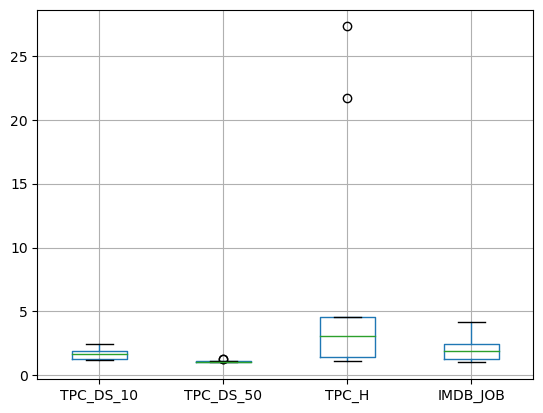

In [ ]:
sample_count = 10
result_dic = {
        "TPC_DS_10": [q_error([labels_DS_10G[i]], [y_estimated_DS_10G[i]]) for i in range(len(labels_DS_10G))],
        "TPC_DS_50": [q_error([y_test_DS_50G[i]], [y_estimated_DS_50G[i]]) for i in range(len(y_test_DS_50G))],
        "TPC_H": [q_error([labels_H[i]], [y_estimated_H[i]]) for i in range(len(labels_H))],
        "IMDB_JOB": [q_error([labels_IMDB[i]], [y_estimated_IMDB[i]]) for i in range(len(labels_IMDB))],
        # "DSB": [q_error([labels_DSB[i]], [y_estimated_DSB[i]]) for i in range(len(labels_DSB))],
    }

df = pd.DataFrame.from_dict({
    "TPC_DS_10": sorted(sample(result_dic["TPC_DS_10"], sample_count)),
    "TPC_DS_50": sorted(sample(result_dic["TPC_DS_50"], sample_count)),
    "TPC_H": sorted(sample(result_dic["TPC_H"], sample_count)),
    "IMDB_JOB": sorted(sample(result_dic["IMDB_JOB"], sample_count)),
})
df.boxplot()
plt.show()

In [37]:
def precision_score(actual, pred, threshold):
    # >= threshold: reduction in cost is significant and hence should not be filtered out
    # < threshold: reduction in cost is insignificant and hence shoud be filtered out
    assert(len(actual) == len(pred))
    fp_count, fn_count, tp_count, tn_count = 0, 0, 0, 0
    total = len(actual)
    for i in range(total):
        if (actual[i] >= threshold) and (pred[i] < threshold): # should not be filtered out but being filtered out
            fp_count += 1
        if (actual[i] < threshold) and (pred[i] >= threshold): # should be filtered out but not being filtered out
            fn_count += 1
        if (actual[i] >= threshold) and (pred[i] >= threshold):
            tp_count += 1
        if (actual[i] < threshold) and (pred[i] < threshold):
            tn_count += 1
    assert(fp_count+fn_count+tp_count+tn_count == total)
    return tp_count/total, tn_count/total, fp_count/total, fn_count/total

In [38]:
filter_threshold = 0.05

def get_percentage_diff(data, flattened_ids, actual, pred):
    percentage_diff_list_true, percentage_diff_list_estimated = [], []
    test_set = flattened_ids[int(train_size * len(flattened_ids)):]
    for k, (i,j) in enumerate(test_set):
        costs = data[i][2]
        original_query_cost = costs[j]
        percentage_diff_estimated = (original_query_cost - pred[k])/ original_query_cost
        percentage_diff_true = (original_query_cost - actual[k])/original_query_cost
        percentage_diff_list_estimated.append(percentage_diff_estimated)
        percentage_diff_list_true.append(percentage_diff_true)
    return percentage_diff_list_true, percentage_diff_list_estimated
    
percentage_diff_list_true_DS_10G, percentage_diff_list_estimated_DS_10G = get_percentage_diff(DS_10G_data, single_index_query_ids_DS_10G, y_test_DS_10G, y_estimated_DS_10G)
true_positive, true_negative, false_positive, false_negative = precision_score(percentage_diff_list_true_DS_10G, percentage_diff_list_estimated_DS_10G, filter_threshold)
print(f"False positive rate on TPC-DS 10G: {false_positive}, False negative rate on TPC-DS 10G: {false_negative}")

False positive rate on TPC-DS 10G: 0.0, False negative rate on TPC-DS 10G: 0.37168141592920356


In [39]:
percentage_diff_list_true_DS_50G, percentage_diff_list_estimated_DS_50G = get_percentage_diff(DS_50G_data, single_index_query_ids_DS_50G, labels_DS_50G, y_estimated_DS_50G)
true_positive, true_negative, false_positive, false_negative = precision_score(percentage_diff_list_true_DS_50G, percentage_diff_list_estimated_DS_50G, filter_threshold)
print(f"False positive rate on TPC-DS 50G: {false_positive}, False negative rate on TPC-DS 50G: {false_negative}")

False positive rate on TPC-DS 50G: 0.30638297872340425, False negative rate on TPC-DS 50G: 0.11914893617021277


In [40]:
percentage_diff_list_true_H, percentage_diff_list_estimated_H = get_percentage_diff(H_data, single_index_query_ids_H, labels_H, y_estimated_H)
true_positive, true_negative, false_positive, false_negative = precision_score(percentage_diff_list_true_H, percentage_diff_list_estimated_H, filter_threshold)
print(f"False positive rate on TPC-H: {false_positive}, False negative rate on TPC-H: {false_negative}")

False positive rate on TPC-H: 0.509719222462203, False negative rate on TPC-H: 0.0


In [41]:
percentage_diff_list_true_IMDB, percentage_diff_list_estimated_IMDB = get_percentage_diff(IMDB_data, single_index_query_ids_IMDB, labels_IMDB, y_estimated_IMDB)
true_positive, true_negative, false_positive, false_negative = precision_score(percentage_diff_list_true_IMDB, percentage_diff_list_estimated_IMDB, filter_threshold)
print(f"False positive rate on IMDB: {false_positive}, False negative rate on IMDB: {false_negative}")

False positive rate on IMDB: 0.18604651162790697, False negative rate on IMDB: 0.06976744186046512


In [ ]:
# percentage_diff_list_true_DSB, percentage_diff_list_estimated_DSB = get_percentage_diff(DSB_data, single_index_query_ids_DSB, labels_DSB, y_estimated_DSB)
# true_positive, true_negative, false_positive, false_negative = precision_score(percentage_diff_list_true_DSB, percentage_diff_list_estimated_DSB, filter_threshold)
# print(f"False positive rate on DSB: {false_positive}, False negative rate on DSB: {false_negative}")

False positive rate on DSB: 0.5161290322580645, False negative rate on DSB: 0.0967741935483871


### Index Cost Model

#### clustering

In [47]:
def group_data_by_template(data, template_range):
    templates = {entry[0].nr: [entry] for entry in data if entry[0].nr <= template_range}
    for entry in data:
        query = entry[0]
        if query.nr <= template_range: continue
        suffix = int(str(query.nr)[-2:])
        templates[suffix].append(entry)
    return templates

templates_DS_50G = group_data_by_template(DS_50G_data, 99)
templates_DS_10G = group_data_by_template(DS_10G_data, 99)
templates_H = group_data_by_template(H_data, 22)

In [48]:
# print(f"{templates_H[4][0][0].nr}: {templates_H[4][0][0].text}")
# print(f"{templates_H[4][1][0].nr}: {templates_H[4][1][0].text}")

In [49]:
import os

def get_parameters_for_tpcds(columns, template_id):
    root_path = "tpcds-kit/query_templates"
    filename = f"query{template_id}.tpl"
    params, variables = set(), []
    with open(os.path.join(root_path, filename)) as f:
        for line in f:
            line = line.strip()
            if "define" in line:
                variable = line.split(" ")[1].split("=")[0]
                if "LIMIT" in variable: continue
                if "text" in line:
                    for column in columns.values():
                            if column.name in line:
                                params.add(column)
                variables.append(variable)
            else:
                for var in variables:
                    if var in line:
                        for column in columns.values():
                            if column.name in line:
                                params.add(column)
    return list(params)

TPC_DS_50G_params = get_parameters_for_tpcds(column_dict_DS_50G, 3)
print(TPC_DS_50G_params)

[C store_sales.ss_net_profit, C store_sales.ss_ext_discount_amt, C store_sales.ss_sales_price, C store_sales.ss_ext_sales_price, C item.i_manufact, C date_dim.d_moy, C item.i_manufact_id]


In [50]:
def get_parameters_for_tpch(columns, template_id):
    root_path = "tpch-kit/dbgen/queries"
    filename = f"{template_id}.sql"
    params = set()
    with open(os.path.join(root_path, filename)) as f:
        for line in f:
            line = line.strip()
            if matched := re.search(r"\'?(%?:\d+%?)+\'?", line):
                for column in columns.values():
                    start = matched.span()[0]
                    if (pos := line.find(column.name)) != -1 and pos < start:      
                        params.add(column)    
    return params  
            
TPC_H_params = get_parameters_for_tpch(column_dict_H, 3)
print(TPC_H_params)

{C orders.o_orderdate, C customer.c_mktsegment, C lineitem.l_shipdate}


In [20]:
# feature 1
def calculate_parameter_selectivity(dataset_name, template_id, query_plan, column_dict):
    get_parameters = None
    if re.search("TPC_DS", dataset_name) or re.search("DSB", dataset_name): get_parameters = get_parameters_for_tpcds
    elif re.search("TPCH", dataset_name): get_parameters = get_parameters_for_tpch
    else: raise ValueError("Not supported dataset")
    params = get_parameters(column_dict, template_id)
    selectivities = {param: 0 for param in params}
    _calculate_parameter_selectivity(params, selectivities, query_plan)
    return selectivities

def _calculate_parameter_selectivity(params, selectivities, query_plan):
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _calculate_parameter_selectivity(params, selectivities, child_node)
    if (condition := has_filtering_property(query_plan)) != "":
        for column in params:
            if column.name in condition:
                selectivities[column]= query_plan["Plan Rows"]/column.table.row_count

# feature 2
def evaluate_configuration(column_dict, configuration, query_plan):
    configuration_features = {}
    _evaluate_configuration(column_dict, configuration_features, configuration, query_plan)
    return configuration_features

def _evaluate_configuration(column_dict, configuration_features, configuration, query_plan):
    current_operator = query_plan["Node Type"]
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _evaluate_configuration(column_dict, configuration_features, configuration, child_node)
    column_keys = [column_key for column_key,_ in column_dict.items()]          
    if (condition := has_filtering_property(query_plan)) != "":
        for index in configuration:
            for j, column in enumerate(index.columns):
                if column.name in condition:
                    configuration_features[f"selectivity_{column_keys.index(column.name)}"] = query_plan["Plan Rows"]/column.table.row_count
                    feature = f"operation_{column_keys.index(column.name)}"
                    if feature not in configuration_features.keys(): configuration_features[feature] = set()
                    configuration_features[feature].add(current_operator)
                    feature = f"position_{column_keys.index(column.name)}"
                    if  feature not in configuration_features.keys(): configuration_features[feature] = j
                    else: configuration_features[feature] = min(configuration_features[feature], j)
    elif is_aggregate_operator(current_operator) and "Group Key" in query_plan.keys():
        conditions = query_plan["Group Key"]
        for index in configuration:
            for j, column in enumerate(index.columns):
                for condition in conditions:
                    if column.name in condition:
                        feature = f"operation_{column_keys.index(column.name)}"
                        if feature not in configuration_features.keys(): configuration_features[feature] = set()
                        configuration_features[feature].add(current_operator)
                        feature = f"position_{column_keys.index(column.name)}"
                        if  feature not in configuration_features.keys(): configuration_features[feature] = j
                        else: configuration_features[feature] = min(configuration_features[feature], j)
    elif is_sort_operator(current_operator) and "Sort Key" in query_plan:
        conditions = query_plan["Sort Key"]
        for index in configuration:
            for j, column in enumerate(index.columns):
                for condition in conditions:
                    if column.name in condition:
                        feature = f"order_{column_keys.index(column.name)}"
                        if "DESC" in condition: configuration_features[feature] = "DESC"
                        else: configuration_features[feature] = "ASC" # ascending by default
                        feature = f"position_{column_keys.index(column.name)}"
                        if  feature not in configuration_features.keys(): configuration_features[feature] = j
                        else: configuration_features[feature] = min(configuration_features[feature], j)

In [21]:
def construct_template_features_and_labels(dataset_name, templates, column_dict):
    template_feature_labels = {}
    for template_id, data in templates.items():
        labels = []
        get_parameters = None
        if re.search("TPC_DS", dataset_name) or re.search("DSB", dataset_name): get_parameters = get_parameters_for_tpcds
        elif re.search("TPCH", dataset_name): get_parameters = get_parameters_for_tpch
        else: raise ValueError("Not supported dataset")
        params = get_parameters(column_dict, template_id)
        feature_columns = []
        param_selectivity_columns = [f"param_selectivity_{param.name}" for param in params]
        feature_columns.extend(param_selectivity_columns)
        config_selectivity_columns = list(set(f"selectivity_{col}" for col in range(len(column_dict))))
        feature_columns.extend(config_selectivity_columns)
        config_operation_columns = list(set(f"operation_{col}_{i}" for col in range(len(column_dict)) for i in range(3)))
        feature_columns.extend(config_operation_columns)
        config_position_columns = list(set(f"position_{col}" for col in range(len(column_dict))))
        feature_columns.extend(config_position_columns)
        config_order_columns = list(set(f"order_{col}" for col in range(len(column_dict))))
        feature_columns.extend(config_order_columns)
        query_configs = [(entry[0], config) for entry in data for config in entry[1]]
        features = pd.DataFrame(columns=feature_columns, index=range(len(query_configs)))
        k = 0
        for entry in data:
            index_configs = entry[1]
            costs = entry[2]
            plans = entry[3]
            for j, (config, plan) in enumerate(zip(index_configs, plans)):
                labels.append(costs[j])
                selectivities = calculate_parameter_selectivity(dataset_name, template_id, plan, column_dict)
                for param, value in selectivities.items():
                    features.iloc[k][f"param_selectivity_{param.name}"] = value
                config_feature = evaluate_configuration(column_dict, config, plan)
                for feature_name, value in config_feature.items():
                    if isinstance(value, set):
                        for l, operator in enumerate(list(value)):
                            features.iloc[k][f"{feature_name}_{l}"] = operator
                    else:
                        features.iloc[k][feature_name] = value
                k+=1
        features[param_selectivity_columns+config_selectivity_columns] = features[param_selectivity_columns+config_selectivity_columns].apply(pd.to_numeric)
        features[config_position_columns] = features[config_position_columns].fillna(value=len(config_position_columns))
        features[config_position_columns] = features[config_position_columns].astype('float32')
        features[config_selectivity_columns] = features[config_selectivity_columns].fillna(value=1)
        template_feature_labels[template_id] = (features,labels)
    return template_feature_labels

In [53]:
template_feature_labels_DS_50G = construct_template_features_and_labels("TPC_DS", templates_DS_50G, column_dict_DS_50G)
template_feature_labels_DS_10G = construct_template_features_and_labels("TPC_DS", templates_DS_10G, column_dict_DS_10G)
template_feature_labels_H = construct_template_features_and_labels("TPCH", templates_H, column_dict_H)
template_feature_labels_DS_50G[2][0]

,param_selectivity_d_year,selectivity_285,selectivity_11,selectivity_202,selectivity_349,selectivity_92,selectivity_7,selectivity_80,selectivity_277,selectivity_399,...,order_187,order_88,order_159,order_337,order_130,order_71,order_216,order_201,order_207,order_418
0,0.004997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.004997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.004997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.004997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Modeling

##### Random Forest

In [54]:
def template_feature_modeling_and_prediction(dataset_name, template_feature_labels):
    template_regressors, results = {}, {}
    for template_id, (features, labels) in template_feature_labels.items():
        # convert to one-hot
        features_cat = features.select_dtypes(include="object")
        features_num = features.select_dtypes(exclude="object")
        encoder = OneHotEncoder(sparse_output=False)
        features_cat_encoded = encoder.fit_transform(features_cat)
        features_encoded = np.concatenate((features_num.to_numpy(), features_cat_encoded), axis=1)

        X_train, X_test, y_train, y_test = train_test_split(features_encoded, labels, test_size=0.33, random_state=2024)
        template_regressors[template_id] = RandomForestRegressor(n_estimators=5, max_depth=6, random_state=0).fit(X_train, y_train)
        y_estimated = template_regressors[template_id].predict(X_test)
        error = q_error(y_test, y_estimated)
        results[template_id] = error
        
    results = sorted(list(results.values()))
    avg_all_templates = sum(results)/len(results)
    print(f"{dataset_name}: Average Q-error for all templates (99th percentile): {avg_all_templates}")
    return template_regressors, results
    
_, results_DS_50G = template_feature_modeling_and_prediction("TPC-DS 50G", template_feature_labels_DS_50G)
_, results_DS_10G = template_feature_modeling_and_prediction("TPC-DS 10G", template_feature_labels_DS_10G)
_, results_H = template_feature_modeling_and_prediction("TPC-H", template_feature_labels_H)

TPC-DS 50G: Average Q-error for all templates (99th percentile): 37.36388721944428
TPC-DS 10G: Average Q-error for all templates (99th percentile): 2.464829096945506
TPC-H: Average Q-error for all templates (99th percentile): 1.1225457224930666


In [55]:
percentile = 100

print(np.percentile(results_DS_50G, percentile))
print(np.percentile(results_DS_10G, percentile))
print(np.percentile(results_H, percentile))

2340.680867261136
52.350713599683345
2.0395391857573326


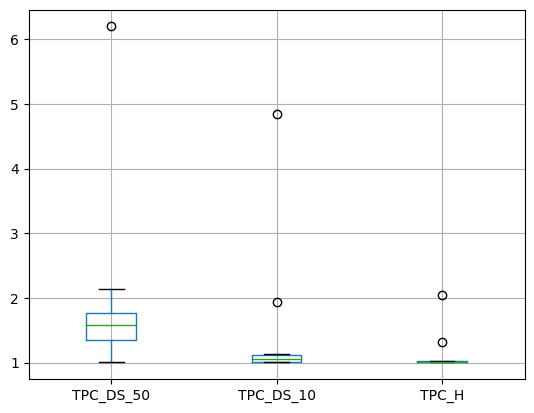

In [56]:
import random
sample_count = 10

df = pd.DataFrame.from_dict({
    "TPC_DS_50": random.sample(results_DS_50G, sample_count),
    "TPC_DS_10": random.sample(results_DS_10G, sample_count),
    "TPC_H": random.sample(results_H, sample_count)
})

df.boxplot()
plt.show()

### Extended Model

In [21]:
def get_metadata_on_dataset(data):
    total_sample_count, max_config_len = 0, 0
    for entry in data:
        total_sample_count += len(entry[1])
        for index_config in entry[1]:
            max_config_len = max(max_config_len, len(index_config))
    return total_sample_count, max_config_len

sample_count_DS_10G, max_config_len_DS_10G = get_metadata_on_dataset(DS_10G_data)
sample_count_DS_50G, max_config_len_DS_50G = get_metadata_on_dataset(DS_50G_data)
sample_count_H, max_config_len_H = get_metadata_on_dataset(H_data)
# sample_count_DSB, max_config_len_DSB = get_metadata_on_dataset(DSB_data)
print(max_config_len_H)

4


In [22]:
MAX_TABLE_NUM = 25
MAX_COLUMN_NUM = 429
MAX_CONFIG_LEN = 4

In [ ]:
def construct_features_and_labels_combined(data, table_dict, column_dict):
    flattened_ids = []
    sample_count, _ = get_metadata_on_dataset(data)
    feature_columns, labels = [], []
    feature_columns.extend(["num_pages", "use_bitmap"])
    utility_columns = [f"utility_of_index{i}"for i in range(MAX_CONFIG_LEN)]
    feature_columns.extend(utility_columns)
    operator_relevance_columns = [f"relevance_{operator}_of_index{i}" for i  in range(MAX_CONFIG_LEN) for operator in LOGICAL_OPERATORS]
    feature_columns.extend(operator_relevance_columns)
    query_shape_columns = [f"query_shape_operator{k}_on_table{j}_of_index{i}" for i in range(MAX_CONFIG_LEN) for j in range(MAX_TABLE_NUM+1) for k in range(5)]
    feature_columns.extend(query_shape_columns)
    index_shape_columns = [f"index_shape_operator{k}_of_index{i}" for i in range(MAX_CONFIG_LEN) for k in range(5)]
    feature_columns.extend(index_shape_columns)
    
    config_selectivity_columns = list(set(f"selectivity_{col}" for col in range(MAX_COLUMN_NUM)))
    feature_columns.extend(config_selectivity_columns)
    config_operation_columns = list(set(f"operation_{col}_{i}" for col in range(MAX_COLUMN_NUM) for i in range(3)))
    feature_columns.extend(config_operation_columns)
    config_position_columns = list(set(f"position_{col}" for col in range(MAX_COLUMN_NUM)))
    feature_columns.extend(config_position_columns)
    config_order_columns = list(set(f"order_{col}" for col in range(MAX_COLUMN_NUM)))
    feature_columns.extend(config_order_columns)

    features = pd.DataFrame(columns=feature_columns, index=range(sample_count))
    k = 0
    for id, entry in enumerate(data):
        index_configs = entry[1]
        costs = entry[2]
        plans = entry[3]
        original_query_plan = plans[0] # no indexed query plan
        original_query_cost = costs[0] # no index query cost
        for j, index_config in enumerate(index_configs):
            labels.append(costs[j])
            indexed_query_plan = plans[j]
            for i, index in enumerate(index_config):
                utility = estimate_index_utility(index, original_query_plan, indexed_query_plan)/original_query_cost
                features.iloc[k][f"utility_of_index{i}"] = utility
                query_shape, index_shape = extract_shape_of_query_and_index(index, original_query_plan, indexed_query_plan)
                table_keys = [table_key for table_key,_ in table_dict.items()]
                for table, operator_seq in query_shape.items():
                    for o, operator in enumerate(operator_seq):
                        if table in table_keys:
                            table_index = table_keys.index(table)
                            features.iloc[k][f"query_shape_operator{o}_on_{table_index}_of_index{i}"] = operator
                for o, operator in enumerate(index_shape):
                    features.iloc[k][f"index_shape_operator{o}_of_index{i}"] = operator
                relevance = evaluate_operator_relevance(index, original_query_plan)
                for operator in LOGICAL_OPERATORS:
                    if operator in relevance: features.iloc[k][f"relevance_{operator}_of_index{i}"] = sum(relevance[operator])/len(relevance[operator])
            num_pages = get_number_of_pages(indexed_query_plan)
            use_bitmap = check_bitmap(indexed_query_plan)
            features.iloc[k][f"num_pages"] = num_pages
            features.iloc[k][f"use_bitmap"] = int(use_bitmap)
            
            config_feature = evaluate_configuration(column_dict, index_config, indexed_query_plan)
            for feature_name, value in config_feature.items():
                if isinstance(value, set):
                    for o, operator in enumerate(list(value)):
                        features.iloc[k][f"{feature_name}_{o}"] = operator
                else:
                    features.iloc[k][feature_name] = value
            flattened_ids.append((id, j))
            k+=1

    features[["num_pages", "use_bitmap"]+utility_columns+operator_relevance_columns+config_selectivity_columns] = features[["num_pages", "use_bitmap"]+utility_columns+operator_relevance_columns+config_selectivity_columns].astype('float32')
    features[operator_relevance_columns] = features[operator_relevance_columns].fillna(value=0)
    features[config_position_columns] = features[config_position_columns].fillna(value=len(config_position_columns))
    features[config_position_columns] = features[config_position_columns].astype('float32')
    features[config_selectivity_columns] = features[config_selectivity_columns].fillna(value=1)
    features[utility_columns] = features[utility_columns].fillna(value=0)
    
    # onehot
    logical_operator_encoder = OneHotEncoder(sparse_output=False, categories=[LOGICAL_OPERATORS+[np.NaN] for _ in range(len(query_shape_columns)+len(index_shape_columns))])
    physical_operator_encoder = OneHotEncoder(sparse_output=False, categories=[PHYSICAL_OPERATORS+[np.NaN] for _ in range(len(config_operation_columns))])
    order_encoder = OneHotEncoder(sparse_output=False, categories=[["ASC", "DESC", np.NaN] for _ in range(len(config_order_columns))])
    features_num = features.select_dtypes(exclude="object")
    logical_operator_features_encoded = logical_operator_encoder.fit_transform(features[query_shape_columns + index_shape_columns])
    physical_operator_features_encoded = physical_operator_encoder.fit_transform(features[config_operation_columns])
    order_features_encoded = order_encoder.fit_transform(features[config_order_columns])
    features_encoded = np.concatenate((features_num.to_numpy(), logical_operator_features_encoded, physical_operator_features_encoded, order_features_encoded), axis=1)
    return features, features_encoded, np.array(labels,dtype='float32'), flattened_ids


features_combined_DS_10G, features_combined_DS_10G_encoded, labels_combined_DS_10G, flattened_ids_combined_DS_10G = construct_features_and_labels_combined(DS_10G_data, table_dict_DS_10G, column_dict_DS_10G)
print("labels:\n", labels_combined_DS_10G)
features_combined_DS_10G

In [71]:
features_combined_DS_50G, features_combined_DS_50G_encoded, labels_combined_DS_50G, flattened_ids_combined_DS_50G = construct_features_and_labels_combined(DS_50G_data, table_dict_DS_50G, column_dict_DS_50G)

In [72]:
features_combined_H, features_combined_H_encoded, labels_combined_H, flattened_ids_combined_H = construct_features_and_labels_combined(H_data, table_dict_H, column_dict_H)
features_combined_DSB, features_combined_DSB_encoded, labels_combined_DSB, flattened_ids_combined_DSB = construct_features_and_labels_combined(DSB_data, table_dict_DSB, column_dict_DSB)

In [78]:
features_combined_JOB, features_combined_JOB_encoded, labels_combined_JOB, flattened_ids_combined_JOB = construct_features_and_labels_combined(IMDB_data, table_dict_IMDB, column_dict_IMDB)

In [73]:
features_combined_DS_50G.shape, features_combined_DS_10G.shape, features_combined_H.shape, features_combined_DSB.shape

((4726, 3136), (28039, 3136), (4471, 3136), (455, 3136))

In [93]:
train_size = 0.67

X_train_combined_DS_10G, X_test_combined_DS_10G, y_train_combined_DS_10G, y_test_combined_DS_10G = train_test_split(features_combined_DS_10G_encoded, labels_combined_DS_10G, test_size=0.33, random_state=2024)
X_train_combined_DS_50G, X_test_combined_DS_50G, y_train_combined_DS_50G, y_test_combined_DS_50G = train_test_split(features_combined_DS_50G_encoded, labels_combined_DS_50G, test_size=0.33, random_state=2024)
X_train_combined_H, X_test_combined_H, y_train_combined_H, y_test_combined_H = train_test_split(features_combined_H_encoded, labels_combined_H, test_size=0.33, random_state=2024)
X_train_combined_JOB, X_test_combined_JOB, y_train_combined_JOB, y_test_combined_JOB = train_test_split(features_combined_JOB_encoded, labels_combined_JOB, test_size=0.33, random_state=2024)

In [94]:
regr = RandomForestRegressor(n_estimators=50, max_depth=23, random_state=0).fit(X_train_combined_DS_50G, y_train_combined_DS_50G)
y_estimated_combined_DS_50G = regr.predict(X_test_combined_DS_50G)
q_error(y_test_combined_DS_50G, y_estimated_combined_DS_50G)

1.6287194670527019

In [95]:
# regr = RandomForestRegressor(n_estimators=50, max_depth=23, random_state=0).fit(X_train_combined_DS_10G, y_train_combined_DS_10G)
y_estimated_combined_DS_10G = regr.predict(X_test_combined_DS_10G)
q_error(y_test_combined_DS_10G, y_estimated_combined_DS_10G)

6.825654382937871

In [96]:
# regr = RandomForestRegressor(n_estimators=50, max_depth=23, random_state=0).fit(X_train_combined_H, y_train_combined_H)
y_estimated_combined_H = regr.predict(X_test_combined_H)
q_error(y_test_combined_H, y_estimated_combined_H)

3.67941698659425

In [97]:
# regr = RandomForestRegressor(n_estimators=50, max_depth=23, random_state=0).fit(X_train_combined_JOB, y_train_combined_JOB)
y_estimated_combined_JOB = regr.predict(X_test_combined_JOB)
q_error(y_test_combined_JOB, y_estimated_combined_JOB)

2.62584849578142

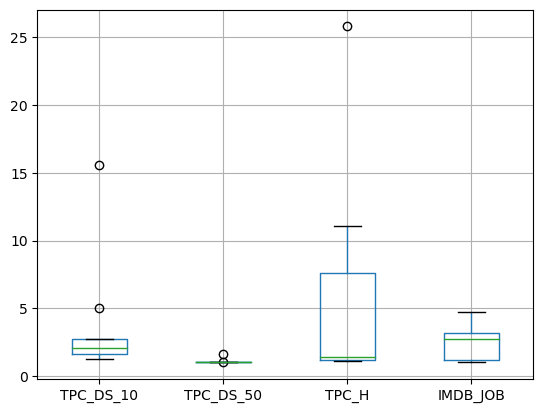

In [106]:
from random import sample

sample_count = 10
result_dic = {
        "TPC_DS_10": [q_error([y_test_combined_DS_10G[i]], [y_estimated_combined_DS_10G[i]]) for i in range(len(y_test_combined_DS_10G))],
        "TPC_DS_50": [q_error([y_test_combined_DS_50G[i]], [y_estimated_combined_DS_50G[i]]) for i in range(len(y_test_combined_DS_50G))],
        "TPC_H": [q_error([y_test_combined_H[i]], [y_estimated_combined_H[i]]) for i in range(len(y_test_combined_H))],
        "IMDB_JOB": [q_error([y_test_combined_JOB[i]], [y_estimated_combined_JOB[i]]) for i in range(len(y_test_combined_JOB))],
    }

df = pd.DataFrame(data = {
    "TPC_DS_10": sorted(sample(result_dic["TPC_DS_10"], sample_count)),
    "TPC_DS_50": sorted(sample(result_dic["TPC_DS_50"], sample_count)),
    "TPC_H": sorted(sample(result_dic["TPC_H"], sample_count)),
    "IMDB_JOB": sorted(sample(result_dic["IMDB_JOB"], sample_count))
})

df.boxplot()
plt.show()

In [107]:
percentile = 100
print(np.percentile(result_dic["TPC_DS_50"], percentile))
print(np.percentile(result_dic["TPC_DS_10"], percentile))
print(np.percentile(result_dic["TPC_H"], percentile))
print(np.percentile(result_dic["IMDB_JOB"], percentile))

335.8080320209354
5044.934871795195
25.962888212559157
42.19263745964304


In [ ]:
percentage_diff_list_true_DS_10G, percentage_diff_list_estimated_DS_10G = get_percentage_diff(DS_10G_data, flattened_ids_combined_DS_10G, y_test_combined_DS_10G, y_estimated_combined_DS_10G)
true_positive, true_negative, false_positive, false_negative = precision_score(percentage_diff_list_true_DS_10G, percentage_diff_list_estimated_DS_10G, filter_threshold)
print(f"False positive rate on TPC-DS 10G: {false_positive}, False negative rate on TPC-DS 10G: {false_negative}")

False positive rate on TPC-DS 10G: 0.013184913001188804, False negative rate on TPC-DS 10G: 0.010050794336971793


In [ ]:
percentage_diff_list_true_DS_50G, percentage_diff_list_estimated_DS_50G = get_percentage_diff(DS_50G_data, flattened_ids_combined_DS_50G, labels_combined_DS_50G, y_estimated_combined_DS_50G)
true_positive, true_negative, false_positive, false_negative = precision_score(percentage_diff_list_true_DS_50G, percentage_diff_list_estimated_DS_50G, filter_threshold)
print(f"False positive rate on TPC-DS 50G: {false_positive}, False negative rate on TPC-DS 50G: {false_negative}")

False positive rate on TPC-DS 50G: 0.025, False negative rate on TPC-DS 50G: 0.28012820512820513


In [ ]:
percentage_diff_list_true_H, percentage_diff_list_estimated_H = get_percentage_diff(H_data, flattened_ids_combined_H, labels_combined_H, y_estimated_combined_H)
true_positive, true_negative, false_positive, false_negative = precision_score(percentage_diff_list_true_H, percentage_diff_list_estimated_H, filter_threshold)
print(f"False positive rate on TPC-H: {false_positive}, False negative rate on TPC-H: {false_negative}")

False positive rate on TPC-H: 0.08536585365853659, False negative rate on TPC-H: 0.08197831978319783


In [ ]:
percentage_diff_list_true_DSB, percentage_diff_list_estimated_DSB = get_percentage_diff(DSB_data, flattened_ids_combined_DSB, labels_combined_DSB, y_estimated_combined_DSB)
true_positive, true_negative, false_positive, false_negative = precision_score(percentage_diff_list_true_DSB, percentage_diff_list_estimated_DSB, filter_threshold)
print(f"False positive rate on DSB: {false_positive}, False negative rate on DSB: {false_negative}")

False positive rate on DSB: 0.11920529801324503, False negative rate on DSB: 0.06622516556291391


### MLP

In [22]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

class MSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        return F.mse_loss(input.view(-1), target.view(-1), reduction='mean')
    
    
class QLoss(nn.Module):
    def __init__(self, weight=None, min_val=1e-5, penalty_negative=1e5):
        self.min_val = min_val
        self.penalty_negative = penalty_negative
        super().__init__()

    def forward(self, input, target):
        qerror = []
        for i in range(len(target)):
            q_err = max(target[i]/input[i], input[i]/target[i])
            qerror.append(q_err)
        return torch.mean(torch.cat(qerror))

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.input_fc = nn.Linear(input_dim, 32)
        self.output_fc = nn.Linear(32, output_dim)
        
    def forward(self, x):
        h_1 = F.relu(self.input_fc(x))
        y_pred = self.output_fc(h_1)
        return y_pred

In [24]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.op_encoders = nn.ModuleList(nn.Linear(6,1) for _ in PHYSICAL_OPERATORS)
        self.fc = MLP(input_dim, output_dim)
        
    def forward(self, x):
        hidden = None
        for op, input in x["op_features"].items():
            id = PHYSICAL_OPERATORS.index(op)
            if hidden == None: hidden = self.op_encoders[id](input)
            else: hidden = torch.cat((hidden, self.op_encoders[id](input)), 1)

        hidden = torch.cat((F.leaky_relu(hidden), x["index_features"], x["table_stats"]),1)
        return self.fc(hidden)
        

In [25]:
def _extract_operator_feature(features, query_plan):
    if has_child_node(query_plan):
        for child_node in query_plan["Plans"]:
            _extract_operator_feature(features, child_node)
            
    current_operator = query_plan["Node Type"]
    op_feature = features[current_operator]
    op_feature["actual_rows"].append(query_plan["Actual Rows"])
    op_feature["actual_loops"].append(query_plan["Actual Loops"])
    op_feature["plan_rows"].append(query_plan["Plan Rows"])
    op_feature["plan_width"].append(query_plan["Plan Width"])
    op_feature["cost"].append(query_plan["Total Cost"] - query_plan["Startup Cost"])
    op_feature["actual_time"].append(query_plan["Actual Total Time"] - query_plan["Actual Startup Time"])

def extract_operator_features(query_plan):
    result = {op: {"actual_rows": [], "actual_loops": [], "plan_rows": [], "plan_width": [], "cost": [], "actual_time": []} for op in PHYSICAL_OPERATORS}
    _extract_operator_feature(result, query_plan)
    for op, v in result.items():
        result[op] = np.array([sum(v["actual_rows"])/len(v["actual_rows"]) if len(v["actual_rows"]) > 0 else 0, 
            sum(v["actual_loops"])/len(v["actual_loops"]) if len(v["actual_loops"]) > 0 else 0,
            sum(v["plan_rows"])/len(v["plan_rows"]) if len(v["plan_rows"]) > 0 else 0,
            sum(v["plan_width"])/len(v["plan_width"]) if len(v["plan_width"]) > 0 else 0,
            sum(v["cost"])/len(v["cost"]) if len(v["cost"]) > 0 else 0,
            sum(v["actual_time"])/len(v["actual_time"]) if len(v["actual_time"]) > 0 else 0,
        ])
    return result

In [26]:
max_column_num_per_table, table_name = 0, None
for _, table in table_dict_DS_50G.items():
    if max_column_num_per_table < len(table.columns):
        max_column_num_per_table = len(table.columns)
        table_name = table.name
for _, table in table_dict_H.items():
    if max_column_num_per_table < len(table.columns):
        max_column_num_per_table = len(table.columns)
        table_name = table.name
for _, table in table_dict_IMDB.items():
    if max_column_num_per_table < len(table.columns):
        max_column_num_per_table = len(table.columns)
        table_name = table.name
print(max_column_num_per_table)
print(table_name)

34
web_sales


In [27]:
def construct_table_features(data, table_dict):
    table_num = 25
    column_per_table = 34
    keys = [f"row_count_{i}" for i in range(table_num)]
    keys.extend([f"n_distinct_{i}_{j}" for i in range(table_num) for j in range(column_per_table)])
    keys.extend([f"null_frac_{i}_{j}" for i in range(table_num) for j in range(column_per_table)])
    table_stats = {k: 0 for k in keys}
    table_names = sorted(list(table_dict.keys()))
    table_list = list(table_dict[k] for k in table_names)
    for i, table in enumerate(table_list):
        table_stats[f"row_count_{i}"] = table.row_count
        for j, column in enumerate(table.columns):
            table_stats[f"n_distinct_{i}_{j}"] = column.cardinality
            table_stats[f"null_frac_{i}_{j}"] = column.null_frac
    sample_count, _ = get_metadata_on_dataset(data)
    for k, v in table_stats.items():
        table_stats[k] = [v for _ in range(sample_count)]
    table_stats = pd.DataFrame.from_dict(table_stats)
    return table_stats

def get_metadata_on_dataset(data):
    total_sample_count, max_config_len = 0, 0
    for entry in data:
        total_sample_count += len(entry[1])
        for index_config in entry[1]:
            max_config_len = max(max_config_len, len(index_config))
    return total_sample_count, max_config_len

In [28]:
MAX_TABLE_NUM = 25
MAX_COLUMN_NUM = 429
MAX_CONFIG_LEN = 4

In [29]:
def construct_operator_index_features(data, table_dict, column_dict):
    sample_count, _ = get_metadata_on_dataset(data)
    index_feature_columns, labels = [], []
    operator_relevance_columns = [f"relevance_{operator}_of_index{i}" for i  in range(MAX_CONFIG_LEN) for operator in LOGICAL_OPERATORS]
    index_feature_columns.extend(operator_relevance_columns)
    query_shape_columns = [f"query_shape_operator{k}_on_table{j}_of_index{i}" for i in range(MAX_CONFIG_LEN) for j in range(MAX_TABLE_NUM+1) for k in range(5)]
    index_feature_columns.extend(query_shape_columns)
    index_shape_columns = [f"index_shape_operator{k}_of_index{i}" for i in range(MAX_CONFIG_LEN) for k in range(5)]
    index_feature_columns.extend(index_shape_columns)
    
    config_operation_columns = list(set(f"operation_{col}_{i}" for col in range(MAX_COLUMN_NUM) for i in range(3)))
    index_feature_columns.extend(config_operation_columns)
    config_position_columns = list(set(f"position_{col}" for col in range(MAX_COLUMN_NUM)))
    index_feature_columns.extend(config_position_columns)
    config_order_columns = list(set(f"order_{col}" for col in range(MAX_COLUMN_NUM)))
    index_feature_columns.extend(config_order_columns)
    
    operator_features = []
    index_features = pd.DataFrame(columns=index_feature_columns, index=range(sample_count))
    k = 0
    for entry in data:
        index_configs = entry[1]
        costs = entry[2]
        plans = entry[3]
        original_query_plan = plans[0] # no indexed query plan
        original_query_cost = costs[0] # no index query cost
        for j, index_config in enumerate(index_configs):
            labels.append(costs[j])
            indexed_query_plan = plans[j]
            for i, index in enumerate(index_config):
                query_shape, index_shape = extract_shape_of_query_and_index(index, original_query_plan, indexed_query_plan)
                table_keys = [table_key for table_key,_ in table_dict.items()]
                for table, operator_seq in query_shape.items():
                    for o, operator in enumerate(operator_seq):
                        if table in table_keys:
                            table_index = table_keys.index(table)
                            index_features.iloc[k][f"query_shape_operator{o}_on_{table_index}_of_index{i}"] = operator
                for o, operator in enumerate(index_shape):
                    index_features.iloc[k][f"index_shape_operator{o}_of_index{i}"] = operator
                relevance = evaluate_operator_relevance(index, original_query_plan)
                for operator in LOGICAL_OPERATORS:
                    if operator in relevance: index_features.iloc[k][f"relevance_{operator}_of_index{i}"] = sum(relevance[operator])/len(relevance[operator])
            
            config_feature = evaluate_configuration(column_dict, index_config, indexed_query_plan)
            for feature_name, value in config_feature.items():
                if isinstance(value, set):
                    for o, operator in enumerate(list(value)):
                        index_features.iloc[k][f"{feature_name}_{o}"] = operator
                else:
                    index_features.iloc[k][feature_name] = value
            operator_features.append(extract_operator_features(indexed_query_plan))
            k+=1

    index_features[operator_relevance_columns] = index_features[operator_relevance_columns].fillna(value=0)
    index_features[config_position_columns] = index_features[config_position_columns].fillna(value=len(config_position_columns))
    
    # onehot
    logical_operator_encoder = OneHotEncoder(sparse_output=False, categories=[LOGICAL_OPERATORS+[np.NaN] for _ in range(len(query_shape_columns)+len(index_shape_columns))])
    physical_operator_encoder = OneHotEncoder(sparse_output=False, categories=[PHYSICAL_OPERATORS+[np.NaN] for _ in range(len(config_operation_columns))])
    order_encoder = OneHotEncoder(sparse_output=False, categories=[["ASC", "DESC", np.NaN] for _ in range(len(config_order_columns))])
    features_num = index_features.select_dtypes(exclude="object")
    logical_operator_features_encoded = logical_operator_encoder.fit_transform(index_features[query_shape_columns + index_shape_columns])
    physical_operator_features_encoded = physical_operator_encoder.fit_transform(index_features[config_operation_columns])
    order_features_encoded = order_encoder.fit_transform(index_features[config_order_columns])
    index_features_encoded = np.concatenate((features_num.to_numpy(), logical_operator_features_encoded, physical_operator_features_encoded, order_features_encoded), axis=1)
    return index_features, index_features_encoded, operator_features, np.array(labels,dtype='float32')

In [30]:
index_features_DS_50G, index_features_encoded_DS_50G, operator_features_DS_50G, labels_DS_50G = construct_operator_index_features(DS_50G_data, table_dict_DS_50G, column_dict_DS_50G)
print("labels:\n", labels_DS_50G)
index_features_DS_50G

labels:
 [18838.602 19060.65  91201.34  ... 39908.49  40009.418 39667.855]


,relevance_Scan_of_index0,relevance_Join_of_index0,relevance_Aggregate_of_index0,relevance_Sort_of_index0,relevance_Scan_of_index1,relevance_Join_of_index1,relevance_Aggregate_of_index1,relevance_Sort_of_index1,relevance_Scan_of_index2,relevance_Join_of_index2,...,order_177,order_45,order_220,order_158,order_290,order_93,order_40,order_263,order_103,order_61
0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,281.956092,281.956092,0,0,0.000000,0.000000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ASC
2,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0.000000,0.000000,0,0,0.002738,0.002738,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4722,0,0,0.002738,0.002738,0,0,0.000000,0.000000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4723,0,0,0.000000,0.000000,0,0,0.002738,0.002738,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4724,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
index_features_DS_10G, index_features_encoded_DS_10G, operator_features_DS_10G, labels_DS_10G = construct_operator_index_features(DS_10G_data, table_dict_DS_10G, column_dict_DS_10G)

In [32]:
index_features_H, index_features_encoded_H, operator_features_H, labels_H = construct_operator_index_features(H_data, table_dict_H, column_dict_H)

In [33]:
index_features_JOB, index_features_encoded_JOB, operator_features_JOB, labels_JOB = construct_operator_index_features(IMDB_data, table_dict_IMDB, column_dict_IMDB)

In [34]:
index_features_encoded_H.shape, index_features_encoded_JOB.shape, index_features_encoded_DS_50G.shape

((4471, 41755), (1138, 41755), (4726, 41755))

In [35]:
table_stats_DS_50G = construct_table_features(DS_50G_data, table_dict_DS_50G)
table_stats_DS_10G = construct_table_features(DS_10G_data, table_dict_DS_10G)
table_stats_H = construct_table_features(H_data, table_dict_H)
table_stats_JOB = construct_table_features(IMDB_data, table_dict_IMDB)
table_stats_DS_50G

,row_count_0,row_count_1,row_count_2,row_count_3,row_count_4,row_count_5,row_count_6,row_count_7,row_count_8,row_count_9,...,null_frac_24_24,null_frac_24_25,null_frac_24_26,null_frac_24_27,null_frac_24_28,null_frac_24_29,null_frac_24_30,null_frac_24_31,null_frac_24_32,null_frac_24_33
0,8.0,11718.0,7197954.0,71997670.0,766000.0,383000.0,1920800.0,73049.0,1.0,7200.0,...,0.0,0.0,0,0,0,0,0,0,0,0
1,8.0,11718.0,7197954.0,71997670.0,766000.0,383000.0,1920800.0,73049.0,1.0,7200.0,...,0.0,0.0,0,0,0,0,0,0,0,0
2,8.0,11718.0,7197954.0,71997670.0,766000.0,383000.0,1920800.0,73049.0,1.0,7200.0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,8.0,11718.0,7197954.0,71997670.0,766000.0,383000.0,1920800.0,73049.0,1.0,7200.0,...,0.0,0.0,0,0,0,0,0,0,0,0
4,8.0,11718.0,7197954.0,71997670.0,766000.0,383000.0,1920800.0,73049.0,1.0,7200.0,...,0.0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721,8.0,11718.0,7197954.0,71997670.0,766000.0,383000.0,1920800.0,73049.0,1.0,7200.0,...,0.0,0.0,0,0,0,0,0,0,0,0
4722,8.0,11718.0,7197954.0,71997670.0,766000.0,383000.0,1920800.0,73049.0,1.0,7200.0,...,0.0,0.0,0,0,0,0,0,0,0,0
4723,8.0,11718.0,7197954.0,71997670.0,766000.0,383000.0,1920800.0,73049.0,1.0,7200.0,...,0.0,0.0,0,0,0,0,0,0,0,0
4724,8.0,11718.0,7197954.0,71997670.0,766000.0,383000.0,1920800.0,73049.0,1.0,7200.0,...,0.0,0.0,0,0,0,0,0,0,0,0


In [36]:
table_stats_DS_50G.shape, table_stats_DS_10G.shape, table_stats_H.shape, table_stats_JOB.shape
table_stats = pd.concat([table_stats_DS_50G, table_stats_DS_10G, table_stats_H, table_stats_JOB], axis=0)
table_stats.shape

(38374, 1725)

In [37]:
operator_features = operator_features_DS_50G + operator_features_DS_10G + operator_features_H + operator_features_JOB
len(operator_features)

38374

In [38]:
index_features_encoded_DS_50G.shape, index_features_encoded_DS_10G.shape, index_features_encoded_H.shape, index_features_encoded_JOB.shape
index_features = np.concatenate((index_features_encoded_DS_50G, index_features_encoded_DS_10G, index_features_encoded_H, index_features_encoded_JOB), axis=0)
index_features.shape

(38374, 41755)

In [39]:
labels = np.concatenate((labels_DS_50G,labels_DS_10G,labels_H,labels_JOB), axis=0)
len(labels)

38374

In [40]:
class CustomDataset(Dataset):
    def __init__(self, operator_features, index_features, table_stats, labels):
        self.operator_features = np.array(operator_features)
        self.index_features = index_features
        self.table_stats = table_stats.to_numpy()
        self.labels = labels
        
    def __getitem__(self, index):
        return {"op_features": self.operator_features[index], "index_features": self.index_features[index], "table_stats": self.table_stats[index]}, self.labels[index]
    
    def __len__(self):
        return len(self.labels)

In [41]:
from torch.utils.data.sampler import SubsetRandomSampler

def create_dataset(operator_features, index_features, table_stats, labels):
    dataset = CustomDataset(operator_features, index_features, table_stats, labels)
    batch_size = 64
    validation_split = .3
    shuffle_dataset = True
    random_seed = 2024

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    return train_loader, validation_loader

In [42]:
INPUT_DIM = len(PHYSICAL_OPERATORS) + len(index_features_encoded_DS_50G[0]) + len(table_stats_DS_50G.columns)
OUTPUT_DIM = 1

# model = LinearModel(INPUT_DIM, OUTPUT_DIM).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0000005)
# criterion = MSELoss()
# print(model)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

In [ ]:
# model.train()
# path = "saved_model.pt"
                      
# num_epochs = 10000
# for epoch in range(num_epochs):
#     losses = []
#     for batch_num, (batch_input, batch_label) in enumerate(train_loader):
#         optimizer.zero_grad()
#         for op, v in batch_input["op_features"].items():
#             batch_input["op_features"][op] = v.to(device, torch.float32)
#         batch_input["index_features"] = batch_input["index_features"].to(device, torch.float32)
#         batch_input["table_stats"] = batch_input["table_stats"].to(device, torch.float32)
        
#         batch_label = batch_label.to(device, torch.float32)
#         output = model(batch_input)
#         loss = criterion(output, batch_label)
        
#         loss.backward()
#         losses.append(loss.item())

#         optimizer.step()

#         if batch_num % 40 == 0:
#             print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
#     torch.save(model, path)
#     print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

In [44]:
model = LinearModel(INPUT_DIM, OUTPUT_DIM).to(device)
model.load_state_dict(torch.load("saved_model_stat_dict_copy.pt"))
model.eval()

LinearModel(
  (op_encoders): ModuleList(
    (0-27): 28 x Linear(in_features=6, out_features=1, bias=True)
  )
  (fc): MLP(
    (input_fc): Linear(in_features=43508, out_features=32, bias=True)
    (output_fc): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [45]:
_, validation_loader_DS_50G = create_dataset(operator_features_DS_50G, index_features_encoded_DS_50G, table_stats_DS_50G, labels_DS_50G)
_, validation_loader_DS_10G = create_dataset(operator_features_DS_10G, index_features_encoded_DS_10G, table_stats_DS_10G, labels_DS_10G)
_, validation_loader_H = create_dataset(operator_features_H, index_features_encoded_H, table_stats_H, labels_H)
_, validation_loader_JOB = create_dataset(operator_features_JOB, index_features_encoded_JOB, table_stats_JOB, labels_JOB)

def validate(model, validation_loader):
    estimates, actuals = [], []
    for _, (batch_input, batch_label) in enumerate(validation_loader):
        for op, v in batch_input["op_features"].items():
            batch_input["op_features"][op] = v.to(device, torch.float32)
        batch_input["index_features"] = batch_input["index_features"].to(device, torch.float32)
        batch_input["table_stats"] = batch_input["table_stats"].to(device, torch.float32)
        batch_estimates = model(batch_input).cpu().detach().numpy().reshape(-1)
        batch_label = batch_label.numpy()
        estimates.extend(list(batch_estimates))
        actuals.extend(list(batch_label))
        # q_errors.append(q_error(batch_label, batch_estimates))
    return estimates, actuals

estimates_DS_50G, actuals_DS_50G = validate(model, validation_loader_DS_50G)
estimates_DS_10G, actuals_DS_10G = validate(model, validation_loader_DS_10G)
estimates_H, actuals_H = validate(model, validation_loader_H)
estimates_JOB, actuals_JOB = validate(model, validation_loader_JOB)

In [46]:
print(q_error(actuals_DS_50G, estimates_DS_50G))
print(q_error(actuals_DS_10G, estimates_DS_10G))
print(q_error(actuals_H, estimates_H))
print(q_error(actuals_JOB, estimates_JOB))

475.77037529593935
69.53694562238142
2.3628752973919163
1.7765838939275371


In [47]:
result_dic = {
    "TPC_DS_50G": [q_error([actuals_DS_50G[i]], [estimates_DS_50G[i]]) for i in range(len(actuals_DS_50G))],
    "TPC_DS_10G": [q_error([actuals_DS_10G[i]], [estimates_DS_10G[i]]) for i in range(len(actuals_DS_10G))],
    "TPC_H" : [q_error([actuals_H[i]], [estimates_H[i]]) for i in range(len(actuals_H))],
    "IMDB_JOB": [q_error([actuals_JOB[i]], [estimates_JOB[i]]) for i in range(len(actuals_JOB))],
}

In [52]:
percentile = 100
print(np.percentile(result_dic["TPC_DS_50G"], percentile))
print(np.percentile(result_dic["TPC_DS_10G"], percentile))
print(np.percentile(result_dic["TPC_H"], percentile))
print(np.percentile(result_dic["IMDB_JOB"], percentile))

345188.4235610019
128109.19063709957
18.883376576080273
18.647597924639744


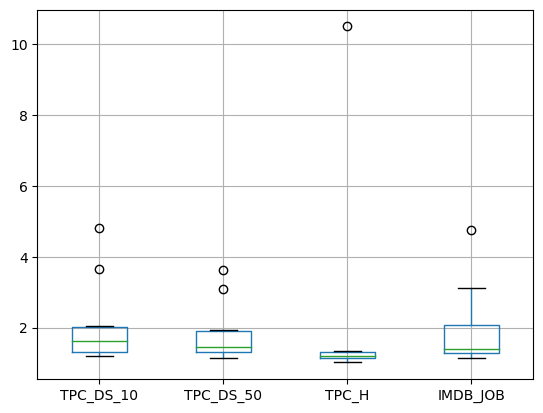

In [56]:
from random import sample
sample_count = 10
df = pd.DataFrame(data = {
    "TPC_DS_10": sorted(sample(result_dic["TPC_DS_10G"], sample_count)),
    "TPC_DS_50": sorted(sample(result_dic["TPC_DS_50G"], sample_count)),
    "TPC_H": sorted(sample(result_dic["TPC_H"], sample_count)),
    "IMDB_JOB": sorted(sample(result_dic["IMDB_JOB"], sample_count))
})

df.boxplot()
plt.show()

In [157]:
INPUT_DIM = 42190
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
criterion = MSELoss()
print(model)

MLP(
  (input_fc): Linear(in_features=42190, out_features=32, bias=True)
  (output_fc): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
epochs = 10000

model.train()

for epoch in range(epochs):
    losses = []
    for batch_num, (batch_input, batch_label) in enumerate(train_loader):
        optimizer.zero_grad()
        batch_input = batch_input.to(device, torch.float32)
        batch_label = batch_label.to(device,torch.float32)
        output = model(batch_input)
        loss = criterion(output, batch_label)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

        if batch_num % 40 == 0:
            print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

	Epoch 0 | Batch 0 | Loss 168868720.00
	Epoch 0 | Batch 40 | Loss 43889736.00
	Epoch 0 | Batch 80 | Loss 15292338.00
	Epoch 0 | Batch 120 | Loss 42534776.00
	Epoch 0 | Batch 160 | Loss 55118660.00
	Epoch 0 | Batch 200 | Loss 102404240.00
	Epoch 0 | Batch 240 | Loss 26973768.00
	Epoch 0 | Batch 280 | Loss 28395008.00
Epoch 0 | Loss 683001746.03
	Epoch 1 | Batch 0 | Loss 11523412.00
	Epoch 1 | Batch 40 | Loss 43456264.00
	Epoch 1 | Batch 80 | Loss 1007229312.00
	Epoch 1 | Batch 120 | Loss 51614500.00
	Epoch 1 | Batch 160 | Loss 55254996.00
	Epoch 1 | Batch 200 | Loss 18617336.00
	Epoch 1 | Batch 240 | Loss 22876464.00
	Epoch 1 | Batch 280 | Loss 15509198.00
Epoch 1 | Loss 155828280.73
	Epoch 2 | Batch 0 | Loss 18795264.00
	Epoch 2 | Batch 40 | Loss 120083312.00
	Epoch 2 | Batch 80 | Loss 171503040.00
	Epoch 2 | Batch 120 | Loss 30483456.00
	Epoch 2 | Batch 160 | Loss 41743988.00
	Epoch 2 | Batch 200 | Loss 17684996.00
	Epoch 2 | Batch 240 | Loss 44479436.00
	Epoch 2 | Batch 280 | Loss 31